In [1]:
import os
import re
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wombat.engine import ml_model
from wombat.engine import parse_input_description as parse_title
from wombat.models import Item
from sklearn import linear_model
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from wombat.models import dbsession, engine, ItemType, ItemAdjective
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,12)

In [70]:
# get list of adjective features form database
features_adj = [f.name for f in dbsession.query(ItemAdjective).all()]
item_types   = [item.name for item in dbsession.query(ItemType).all()]

# take the title and one-hot it using adjectives from 'feature_adj'
tokenized_titles = []
for title in df['title']:
    parse_title.create_one_hot_row_adj(title, features_adj)
    tokenized_titles.append(parse_title.create_one_hot_row_adj(title, features_adj))
df_adj = pd.DataFrame(tokenized_titles, columns = features_adj)

# this one used both title and description
tokenized_titles = []
for text_array in df[['title', 'description']].values:
    try:
        text = ' '.join(text_array)
    except TypeError:
        text = title
    #parse_title.create_one_hot_row_adj(text, features_adj)
    tokenized_titles.append(parse_title.create_one_hot_row_adj(text, features_adj))
df_adj = pd.DataFrame(tokenized_titles, columns = features_adj)

In [71]:
# concatenate (one-hotted brands, item types) and (adjectives)
df = pd.concat([df, df_adj], axis = 1)

In [94]:
# drop columns that we don't want to use as features in our model
excluded_features = ['rent_per_week', 'title', 'cost', 'is_train', 'description']
features = df.columns.drop(excluded_features)

def log_trans(x):
    return 1 + np.log(x)

df['log_rent'] = df['rent_per_week'].apply(log_trans)

# split one-hotted df into true and false subets
train, test = df[df['is_train']==True], df[df['is_train']==False]

In [100]:
#clf = svm.SVR() # didn't work. Predicted 43 for everything
#reg = linear_model.LinearRegression() # total crap
reg = linear_model.Ridge(alpha = .5) # comparable to rfr
#reg = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0]) # comparable to rfr 
#reg = linear_model.Lasso(alpha = 0.1)
#reg = linear_model.ElasticNet(alpha=0.1) # comparable to rfr 
#reg = linear_model.RANSACRegressor(linear_model.LinearRegression()) # slow, did not finish, uses lots of cpu
#reg = linear_model.TheilSenRegressor() # slow, did not finish, uses lots of cpu
#reg = linear_model.HuberRegressor() # slow, did not finish, uses lots of cpu
#reg.fit(train[features], train['rent_per_week'])

In [112]:
# setup rfr
clf = RandomForestRegressor(n_jobs=2, n_estimators=15)

# create model and prediction array
target_set = train['log_rent']
#clf.fit(train[features], target_set)
reg = linear_model.Ridge(alpha = .5) # comparable to rfr
reg.fit(train[features], target_set)
predicted = reg.predict(test[features])
#print(test['log_rent'])
#print(predicted)
target_set
new_df = pd.DataFrame(predicted)

In [102]:
print(predicted.shape)
print(target_set.shape)

(1464,)
(4298,)


In [ ]:
# saving pickled file

#model_dir = '/home/patrick/Dropbox/insight/wombat/wombat/engine/stat_model_pickles'
#model_path = os.path.join(model_dir, 'rfr_v0.1_no_adj.pkl')
#joblib.dump(reg, model_path)
#call this with: clf = joblib.load('huber_v0.1.pkl')

In [9]:
#reg.fit(train[features], train['rent_per_week'])
#r2 = reg.score(train[features], train['rent_per_week'])
#predicted = reg.predict(test[features])

0.63909411656653037

Length of df_full_test: 1464


/home/patrick/.virtualenvs/stylelend/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/patrick/.virtualenvs/stylelend/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/patrick/.virtualenvs/stylelend/lib/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

array([ 5.59472585,  5.48814651,  4.55549422, ...,  6.02215786,
        4.73747869,  6.86174667])

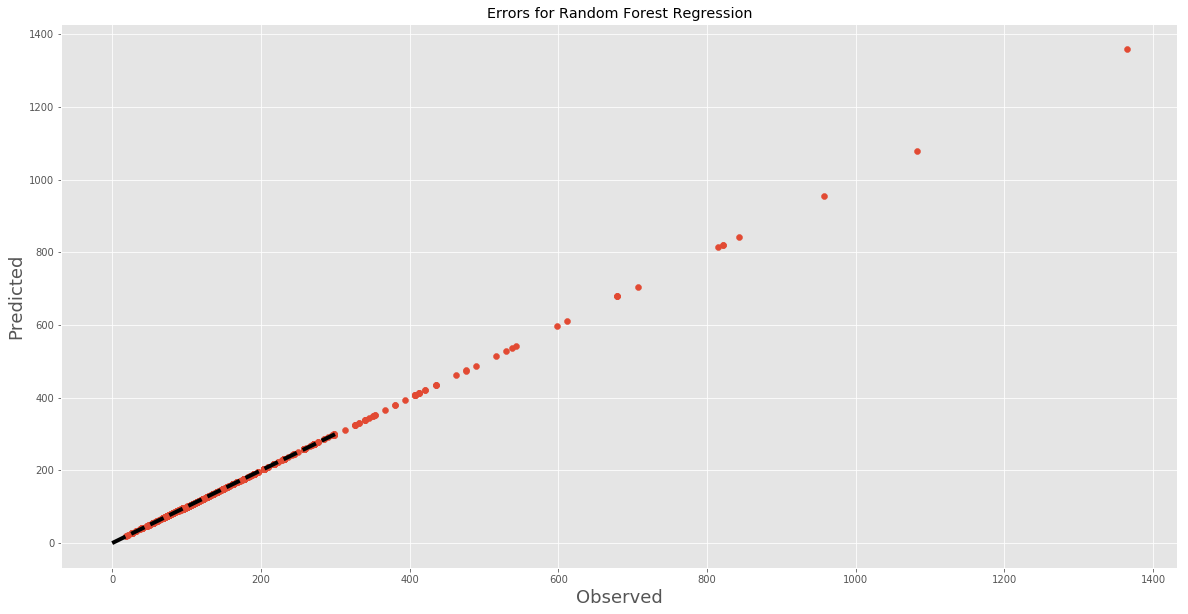

In [106]:
#print("Mean squared error: %.2f"
#      % np.mean((reg.predict(x) - y) ** 2))

# Plot outputs
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(x = np.exp(test['log_rent']), y = np.exp(predicted))
stopping_value = 300
ax.plot([0, stopping_value], [0, stopping_value], 'k--', lw=4)
ax.set_title('Errors for Random Forest Regression')
ax.set_xlabel('Observed', fontsize=18)
ax.set_ylabel('Predicted', fontsize=18)

x = test['rent_per_week']
df_full_test['predicted_rent'] = predicted
#df_full_test['error'] = df_full_test[['rent_per_week', 'predicted_rent']].subtract(axis=1)
df_full_test['error'] = df_full_test['rent_per_week'] - df_full_test['predicted_rent']
print("Length of df_full_test: {}".format(len(df_full_test)))
df_full_test['error'] = df_full_test['error'].abs()
#df_error = df_full_test.loc[df_full_test['error']>0][['brand', 'item_type', 'title', 'error', 'description']].sort_values('error', ascending = 0)
#reg.score(x, y)
#print("Length of df_error: {}".format(len(df_error)))
new_df = pd.Series()
test['log_rent']
predicted

In [104]:
df_full_test

,brand,item_type,title,cost,rent_per_week,description,is_train,predicted_rent,error
0,Self-Portrait,dresses,Ava guipure lace mini dress,520.00,99.0,"Self-Portrait's 'Ava' mini dress is perfect for party season - team it with heels or layer it over tights as the weather cools. Cut from midnight-blue guipure lace, it has a fitted bodice and structured tiered hem for subtle volume. We like that it's left partly unlined to show a touch of skin.\n",False,5.594726,93.405274
6,ML Monique Lhuillier,dresses,Lace Backout Gown,798.00,89.0,This dress is perfect for your next formal occasion and it's a lace dream! It has a back cutout and a back slit that makes it easy to move in. The color is a beautiful cobalt blue. Dress it up with a nice sparkly silver clutch!,False,5.488147,83.511853
12,Jetset Diaries,dresses,The Jetset Diaries Cirrus Maxi Dress,259.00,35.0,Maxi silhouette.\nLightweight rayon fabrication features gorgeous embroidered panels throughout.\nLace-up detail at plunging V-neckline.\nLong sleeves.\nSmocked waist for a flattering shape.,False,4.555494,30.444506
19,Keepsake the Label,dresses,KEEPSAKE THE LABEL Easy Love Long Sleeve Mini Dress,225.00,35.0,Sultry sheath silhouette.\nSweetheart illusion neckline with crochet overlay.\nAdjustable straps with could shoulder design.\nLong sleeves.\nBack-zip closure.\nAsymmetrical hemline.,False,4.555629,30.444371
32,Self Portrait,dresses,Self Portrait Louisa Guipure Dress,462.00,65.0,"The guipure dress features a dot mesh bib, framed with a chiffon organza ruffle and our signature fagotting trim. The waist detail comprises a combination of lace trims to give a waisted fit to the silhouette. The dress is finished with a row of fagotting and a subtle hem frill. The dress fastens at the back with a concealed zip.",False,5.174359,59.825641
33,Self Portrait,dresses,Ava Guipure Lace Mini dress,421.00,65.0,\n\nThis mini dress by Self Portrait features a beautiful midnight blue floral guipure lace all over with a Victorian inspired neck-line . It is partially lined to allow the lace to contrast strikingly against the skin and the body con silhouette is offset by a tiered skirt. Feminine and fashion forward this stunning mini dress is a statement piece! \n,False,5.174474,59.825526
35,Emilio Pucci,dresses,Emilio Pucci dress,400.00,35.0,casual,False,4.556069,30.443931
49,Alaia,dresses,Scoop Neck Fit and Flare,4025.00,160.0,"Go ultra glamorous in this gorgeous Alaia dress! Perfect for cocktail hour, this lovely fit-n-flare piece is sure to offer a luxurious and flexible wear. A unique square neckline provides a flirty detail along with a fabulous knit design throughout. Pair with pumps or go more casual with flats, either way, you'll be turning heads all night long! This dress features a fitted waist and flared skirt and intricate detailing throughout the piece. Sleeveless. Round neckline. Concealed back zip fastening. Fits true to size. \n\nDress is in white - silver is just for image reference (same dress different color)",False,6.073240,153.926760
50,no brand,dresses,little black dress,50.00,10.0,V neck dress with beads,False,3.304549,6.695451
51,The Jetset Diaries,dresses,The Jetset Diaries Golden Island Maxi Dress,239.00,45.0,Maxi silhouette.\nVibrant solid print allover a poly fabrication.\nHigh halter neckline.\nDouble button-loop closure at nape.\nSleeveless.\nKeyhole cutout at front of bodice.\nOpen back.,False,4.806347,40.193653


In [96]:
pd.set_option('display.max_colwidth', -1)

#d_errors = df_error.sort_values('error', ascending=False)
binwidth = 50
bins = list(range(0, 1000 + binwidth, binwidth))
l = []
#for i in bins:
#    y = len(d[d['error'] < i+1]) & (d[d['error'] >= i]))
#    x = i
#    l.append((x,y))
#lower = 0
#upper = 50
#d_errors = df_error.sort_values('error', ascending=True)
#num_high_errors = d_errors[(d_errors['error'] > 30) & (d_errors['error'] < 1000)]
#len(num_high_errors)
#num_low_errors = d_errors[(d_errors['error'] > 0) & (d_errors['error'] < 10)]
#print(len(num_low_errors)/len(num_high_errors))
#print(len(num_low_errors)/len(d_errors))
#print(len(num_low_errors))
d_errors = df_full_test
num_low_errors = d_errors[(d_errors['error'] > 0) & (d_errors['error'] < 20)]
num_high_errors = d_errors[(d_errors['error'] > 20) & (d_errors['error'] < 1000)]
print(len(num_low_errors))
print(len(num_low_errors)/len(d_errors))
print(len(num_high_errors))
d_errors = df_full_test.sort_values('error', ascending=True)
d_errors

120
0.08196721311475409
1344


,brand,item_type,title,cost,rent_per_week,description,is_train,predicted_rent,error
4974,Aldo,accessories,The Zoe,45.00,7.0,Turquoise braided necklace,False,4.225011,2.774989
1111,Lush,dresses,Burgundy lace skater dress,54.00,8.0,This is a stretch lace skater dress with a scoop neck and 3/4 length sleeve. Picture gallery includes a white version of the dress from the website.,False,4.654115,3.345885
4973,DearMissJ,accessories,The Gwen,38.00,7.0,"Channel The Great Gatsby himself with this beauty of a bauble wrapped around your neckline. Grace, glitz, and just the right amount of art deco callings make this piece a fun-to-have must-have for any modern day flapper!",False,3.469620,3.530380
3348,Cate and Chloe,accessories,Jewelry Set,40.00,8.0,Necklace and bracelet set.,False,4.176080,3.823920
5670,Rapscity,dresses,Sexy Sapphire,50.00,10.0,Low v in the front with mesh on the top and sides. Comfortable and great for date night or girl's night out.,False,4.830735,5.169265
4204,Sejour,outerwear,Sejour Crepe High/Low Kimono,89.00,10.0,"Dramatic draping at the long back panel adds ripples of billowy movement to an airy georgette-crepe topper with kimono inspiration.\n\n34 1/2"" front length; 43"" back length (size 2X).\nThree-quarter sleeves.\n100% polyester.\n\nPhoto Credit: nordstrom.com",False,4.826549,5.173451
50,no brand,dresses,little black dress,50.00,10.0,V neck dress with beads,False,4.674883,5.325117
1173,for,outerwear,frfffr,25.00,10.0,Ffff,False,4.664169,5.335831
4390,Turkish Street Market,accessories,Turkish Turquoise,75.00,10.0,Bought it in Tel Aviv from a street vendor. Turquoise stunna.\n,False,4.594506,5.405494
732,Custom,accessories,Top Hat,100.00,10.0,Top it off with this Halloween classic.,False,4.568421,5.431579


In [60]:
df_error[df_error['brand']=='Yves Saint Laurent']

,brand,item_type,title,error,description
3775,Yves Saint Laurent,bags,Timeless & Classic Clutch,216.5,This classic YSL clutch will be perfect for yo...
3678,Yves Saint Laurent,shoes,Palais Suede and Python Sandals,117.5,Yves Saint Laurent Palais sandals: almond peep...


In [61]:
 # make plotly plot
import plotly.plotly as py
import plotly.graph_objs as go

brands = df_full_training['brand'].values
item_types = df_full_training['item_type'].values
titles = df_full_training['title'].values
labels = []
for i in list(range(0, len(brands))):
    labels.append("{}, {}, {}".format(brands[i], item_types[i], titles[i]))

data = [
    go.Scatter(
        x=test['rent_per_week'],
        y=rfr_predicted,
        mode='markers',
        text=labels
    )
]
layout = go.Layout(
    title='Measured vs Predicted outcomes using Random Forest model'
)
fig = go.Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='meas-v-pred-rfr-2017-06-12')

Coefficients: 
 [ 0.21280168]
Mean squared error: 508.92
Variance score: 0.10


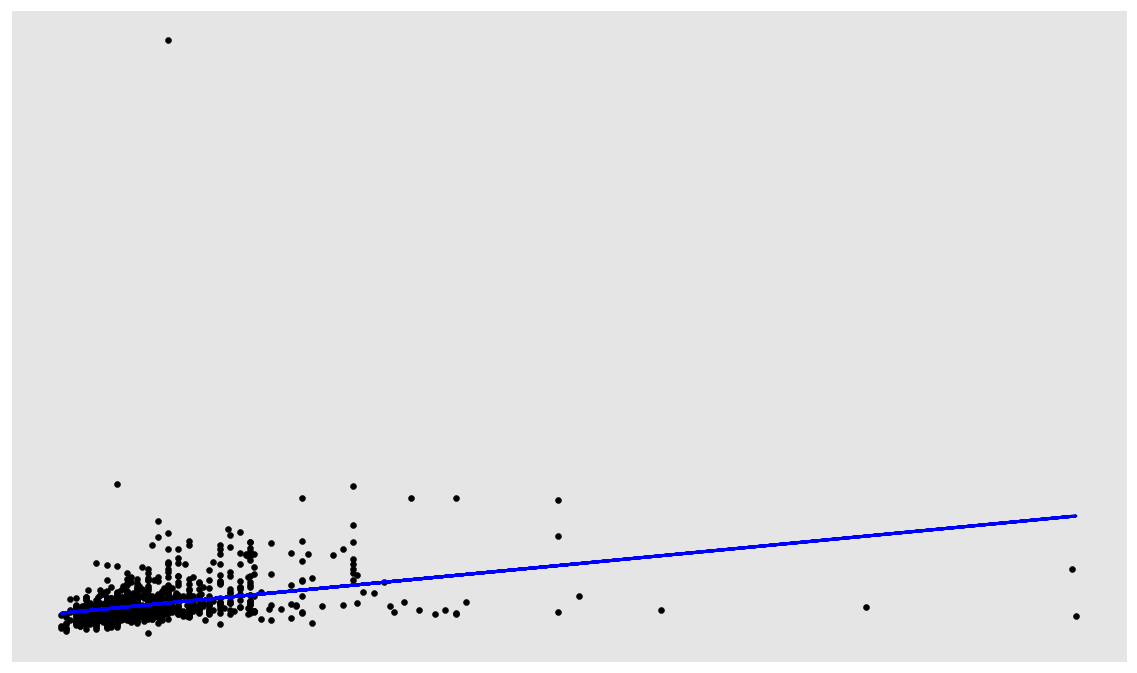

In [62]:
from sklearn import linear_model
# Create linear regression object
reg = linear_model.LinearRegression()

x = test['rent_per_week'].values.reshape(-1,1)
y = np.array(rfr_predicted)

# Train the model using the training sets
reg.fit(x, y)
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((reg.predict(x) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % reg.score(x, y))

# Plot outputs
plt.scatter(x, y,  color='black')
plt.plot(x, reg.predict(x), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()